### IMPORTAR PAQUETES A UTILIZAR <br> PREPROCESAMIENTO DE DATOS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

# Detectar la codificación de caracteres del archivo (problemas con los acentos)

with open('API_EG.ELC.RNEW.ZS_DS2_es_csv_v2_252841.csv', 'rb') as file:
    formato = chardet.detect(file.read())

pd.set_option('display.max_rows', 10)

ds = pd.read_csv('API_EG.ELC.RNEW.ZS_DS2_es_csv_v2_252841.csv', encoding = 'UTF-8', sep = ';')

# Saltear las primeras 4 filas
ds = pd.read_csv('API_EG.ELC.RNEW.ZS_DS2_es_csv_v2_252841.csv', skiprows=4)

# Eliminar filas en las cuales no se indica el nombre del país
ds_sin_NaN = ds.dropna(subset=['Country Name'])

# Eliminar las columnas correspondientes a los períodos 1960-1989 y 2016-2023
columnas_eliminar = [str(year) for year in range(1960,1990)]
columnas_eliminar = columnas_eliminar + [str(year) for year in range(2016,2024)]
dataset = ds_sin_NaN.drop(columns=columnas_eliminar)

# Eliminar filas con pocos datos
filas_con_ceros = []
for fila in dataset.index:
   porcentaje = (((dataset == 0.0).sum(axis=1) / len(dataset.columns))* 100)[fila]
   if porcentaje > 50:
        filas_con_ceros.append(fila)
dataset = dataset.drop(filas_con_ceros)

dataset.to_csv("Electricidad_renovable_limpio.csv", encoding = "UTF-8-SIG",sep=",")

### CÁLCULO DE MEDIDAS DE TENDENCIA CENTRAL Y DE VARIABILIDAD

In [ ]:
# Columnas con porcentajes de energías renovables
years= []
for year in range(1990, 2016):
    years.append(str(year))

# Calcular la media por país
dataset['media'] = dataset[years].mean(axis=1)

# Calcular mediana por país
dataset['mediana'] = dataset[years].median(axis=1)

# Calcular la desviación estándar por país
dataset['std'] = dataset[years].std(axis=1)

# Calcular la media por año
media_anual = dataset[years].mean()


### CÁLCULO DE MEDIDAS DE TENDENCIA TEMPORAL

In [ ]:
# Función para calcular el TCPA (Tasa de Crecimiento Promedio Anual)
def calcular_tcpa(row):
    valor_inicial = None
    for year in range(1990, 2016):
        if row[str(year)] != 0:
            valor_inicial = row[str(year)]
            break
    if valor_inicial is not None:
        return ((row['2015'] / valor_inicial) ** (1 / 25) - 1) * 100
    else:
        return None

# Función para calcular el PCT (Porcentaje de Cambio Total)
def calcular_pct(row):
    valor_inicial = None
    for year in range(1990, 2016):
        if row[str(year)] != 0:
            valor_inicial = row[str(year)]
            break
    if valor_inicial is not None:
        return ((row['2015'] - valor_inicial) / valor_inicial) * 100
    else:
        return None

# Aplicar las funciones a cada fila usando apply
dataset['TCPA'] = dataset.apply(calcular_tcpa, axis=1)
dataset['PCT'] = dataset.apply(calcular_pct, axis=1)


### DIVIDIR EL DATASET EN PAÍSES Y REGIONES

In [ ]:
# Dividir el dataset en países y regiones
no_paises = ["Corea República de", "inicial del dividendo demográfico",
            "Frágiles y situaciones de conflicto afectados", "Unión Europea",
            "Ingreso alto", "Oriente Medio y Norte de África",
            "Ingreso Mediano", "América del Norte", "Miembros OCDE",
            "Otros estados pequeos", "Asia Meridional",
            "África al sur del Sahara (excluido altos ingresos)",
            "África al sur del Sahara", "Pequeños estados", "No clasificado",
            "República Centroafricana", "Europa Central y del Báltico",
            "Congo, República Democrática del", "El mundo árabe",
            "Asia oriental y el Pacífico (excluido altos ingresos)",
            "Asia oriental y el Pacífico",
            "Europa y Asia central (excluido altos ingresos)",
            "Europa y Asia central", "Estados pequeos del Caribe",
            "Zona del Euro", "Sólo BIRF", "BIRF y la AIF", "total de la AIF",
            "mezcla de la AIF", "Sólo AIF", "Países pobres muy endeudados (PPME)",
            "América Latina y el Caribe (excluido altos ingresos)",
            "América Latina y el Caribe",
            "Países menos desarrollados: clasificación de las Naciones Unidas",
            "Países de ingreso bajo", "Países de ingreso mediano bajo",
            "Ingreso mediano y bajo", "avanzada del dividendo demográfico",
            "Ingreso mediano", "Ingreso mediano",
            "Oriente Medio y Norte de África (excluido altos ingresos)",
            "Ingreso mediano", "previa al dividendo demográfico",
            "posterior al dividendo demográfico",
            "Estados pequeos de las Islas del Pacífico",
            "Asia oriental y el Pacífico (BIRF y la AIF)",
            "Europa y Asia central (BIRF y la AIF)",
            "América Latina y el Caribe (BIRF y la AIF)",
            "Oriente Medio y Norte de África (BIRF y la AIF)",
            "Asia meridional (BIRF y la AIF)",
            "África al sur del Sahara (BIRF y la AIF)",
            "Ingreso mediano alto", "Mundo"]
regiones = ["Unión Europea","El mundo árabe",
            "Asia oriental y el Pacífico (excluido altos ingresos)",
            "Asia oriental y el Pacífico",
            "Europa y Asia central (excluido altos ingresos)",
            "Europa y Asia central", "Estados pequeos del Caribe",
            "América Latina y el Caribe (excluido altos ingresos)",
            "América Latina y el Caribe",
            "Oriente Medio y Norte de África (excluido altos ingresos)",
            "Estados pequeos de las Islas del Pacífico"]
ds_paises = dataset.loc[~dataset['Country Name'].isin(no_paises)]
ds_regiones = dataset.loc[dataset['Country Name'].isin(regiones)]

In [ ]:
# Calcular los cuartiles y el rango intercuartílico para identificar los valores
# atípicos del PCT
Q1 = ds_paises['PCT'].quantile(0.25)
Q3 = ds_paises['PCT'].quantile(0.75)
IQR = Q3 - Q1
umbral = 1.5
filtro_atipicos = (ds_paises['PCT'] >= Q1 - umbral * IQR) & (ds_paises['PCT'] <= Q3 + umbral * IQR)
ds_paises_filtrado_PCT = ds_paises[filtro_atipicos]

In [ ]:
# Calcular los cuartiles y el rango intercuartílico para identificar los valores
# atípicos del TCPA
Q1 = ds_paises['TCPA'].quantile(0.25)
Q3 = ds_paises['TCPA'].quantile(0.75)
IQR = Q3 - Q1
umbral = 1.5
filtro_atipicos = (ds_paises['TCPA'] >= Q1 - umbral * IQR) & (ds_paises['TCPA'] <= Q3 + umbral * IQR)
ds_paises_filtrado_TCPA = ds_paises[filtro_atipicos]


### GRÁFICOS

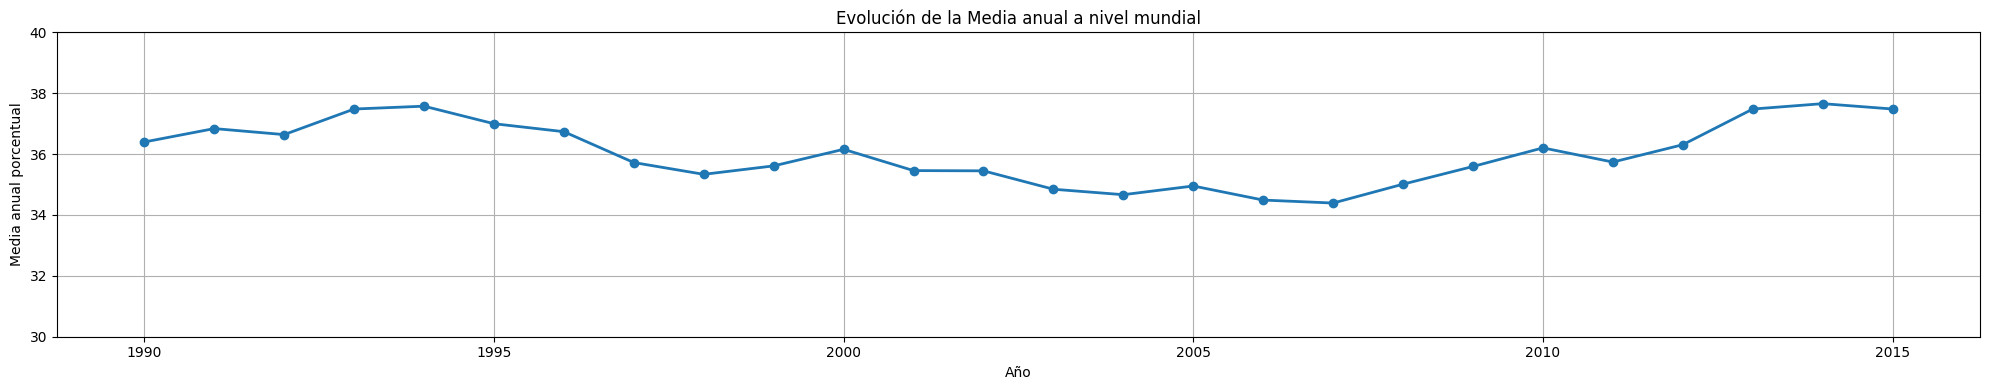

In [ ]:
# Graficar la media por año como un gráfico de líneas

# Ajustar el tamaño del gráfico
plt.figure(figsize=(20, 4))

# Crear gráfico
media_anual.plot(marker='o', linestyle='-', linewidth=2, markersize=6)

# Título y etiquetas de los ejes
plt.title('Evolución de la Media anual a nivel mundial')
plt.xlabel('Año')
plt.ylabel('Media anual porcentual')

# Ajustar límites del eje y
plt.ylim(30, 40)

# Mostrar grilla
plt.grid(True)

# Evitar recortes de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

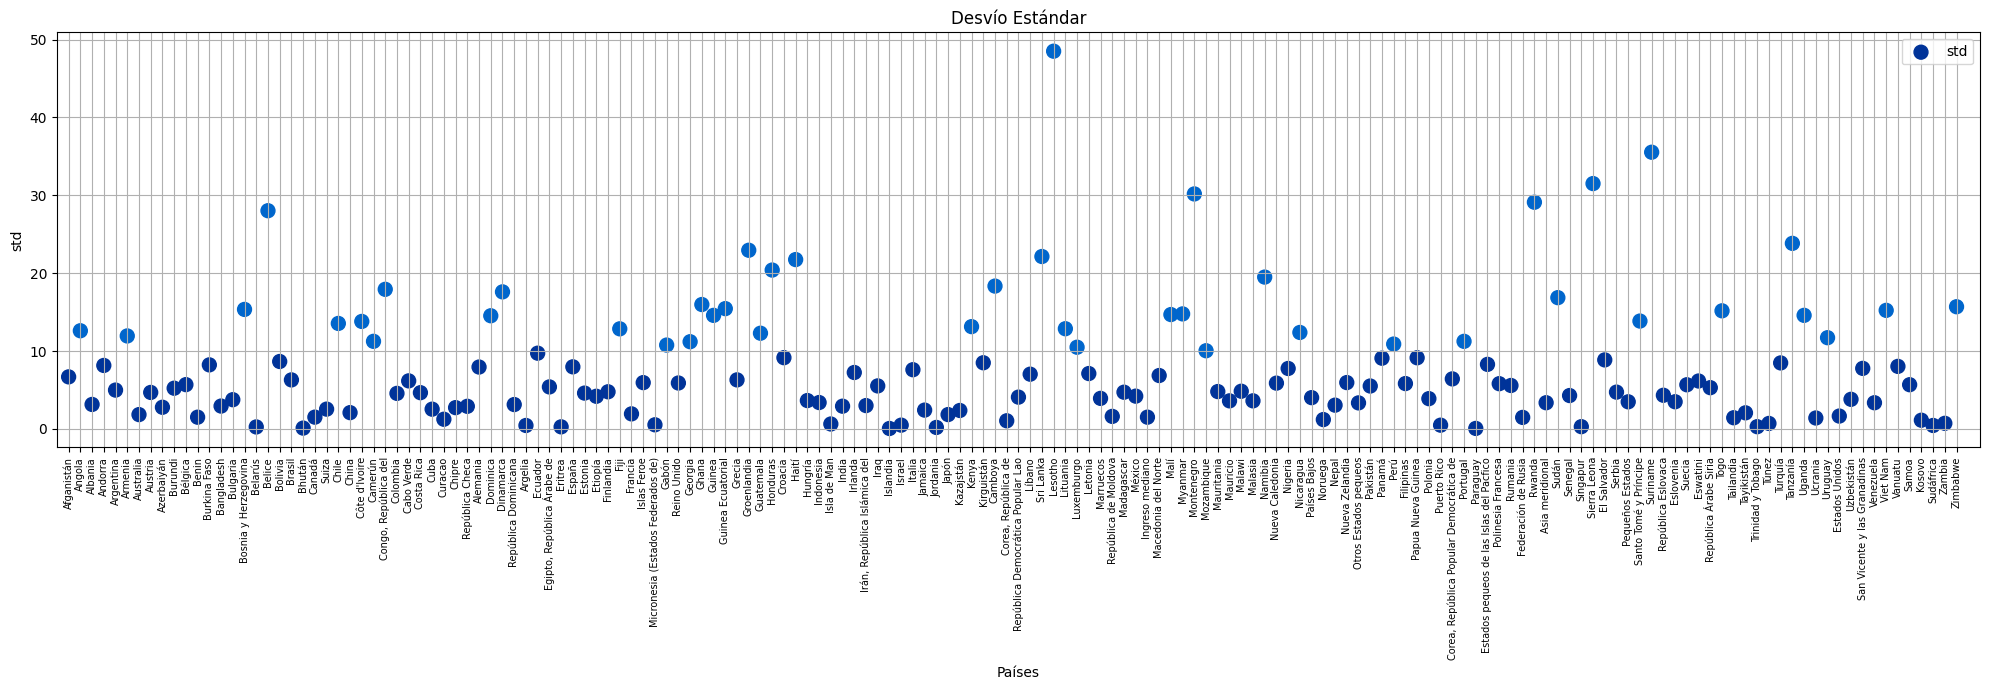

In [ ]:
# # Crear el gráfico de dispersión del std

# Ajustar el tamaño del gráfico
plt.figure(figsize=(20, 7))

# Crear el gráfico distinguiendo los valores de std menores a 10
plt.scatter(ds_paises['Country Name'], ds_paises['std'],
            c=['#003399' if std < 10 else '#0066cc' for std in ds_paises['std']],
            marker='o', s=100, label='std')

# Título y etiquetas de los ejes
plt.xlabel('Países')
plt.ylabel('std')
plt.title('Desvío Estándar')
plt.legend()
plt.xticks(rotation=90, fontsize=7)

#Ajustar límites eje x
plt.xlim(-1, len(ds_paises.index) + 1)

# Mostrar grilla
plt.grid(True)

# Evitar recortes de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

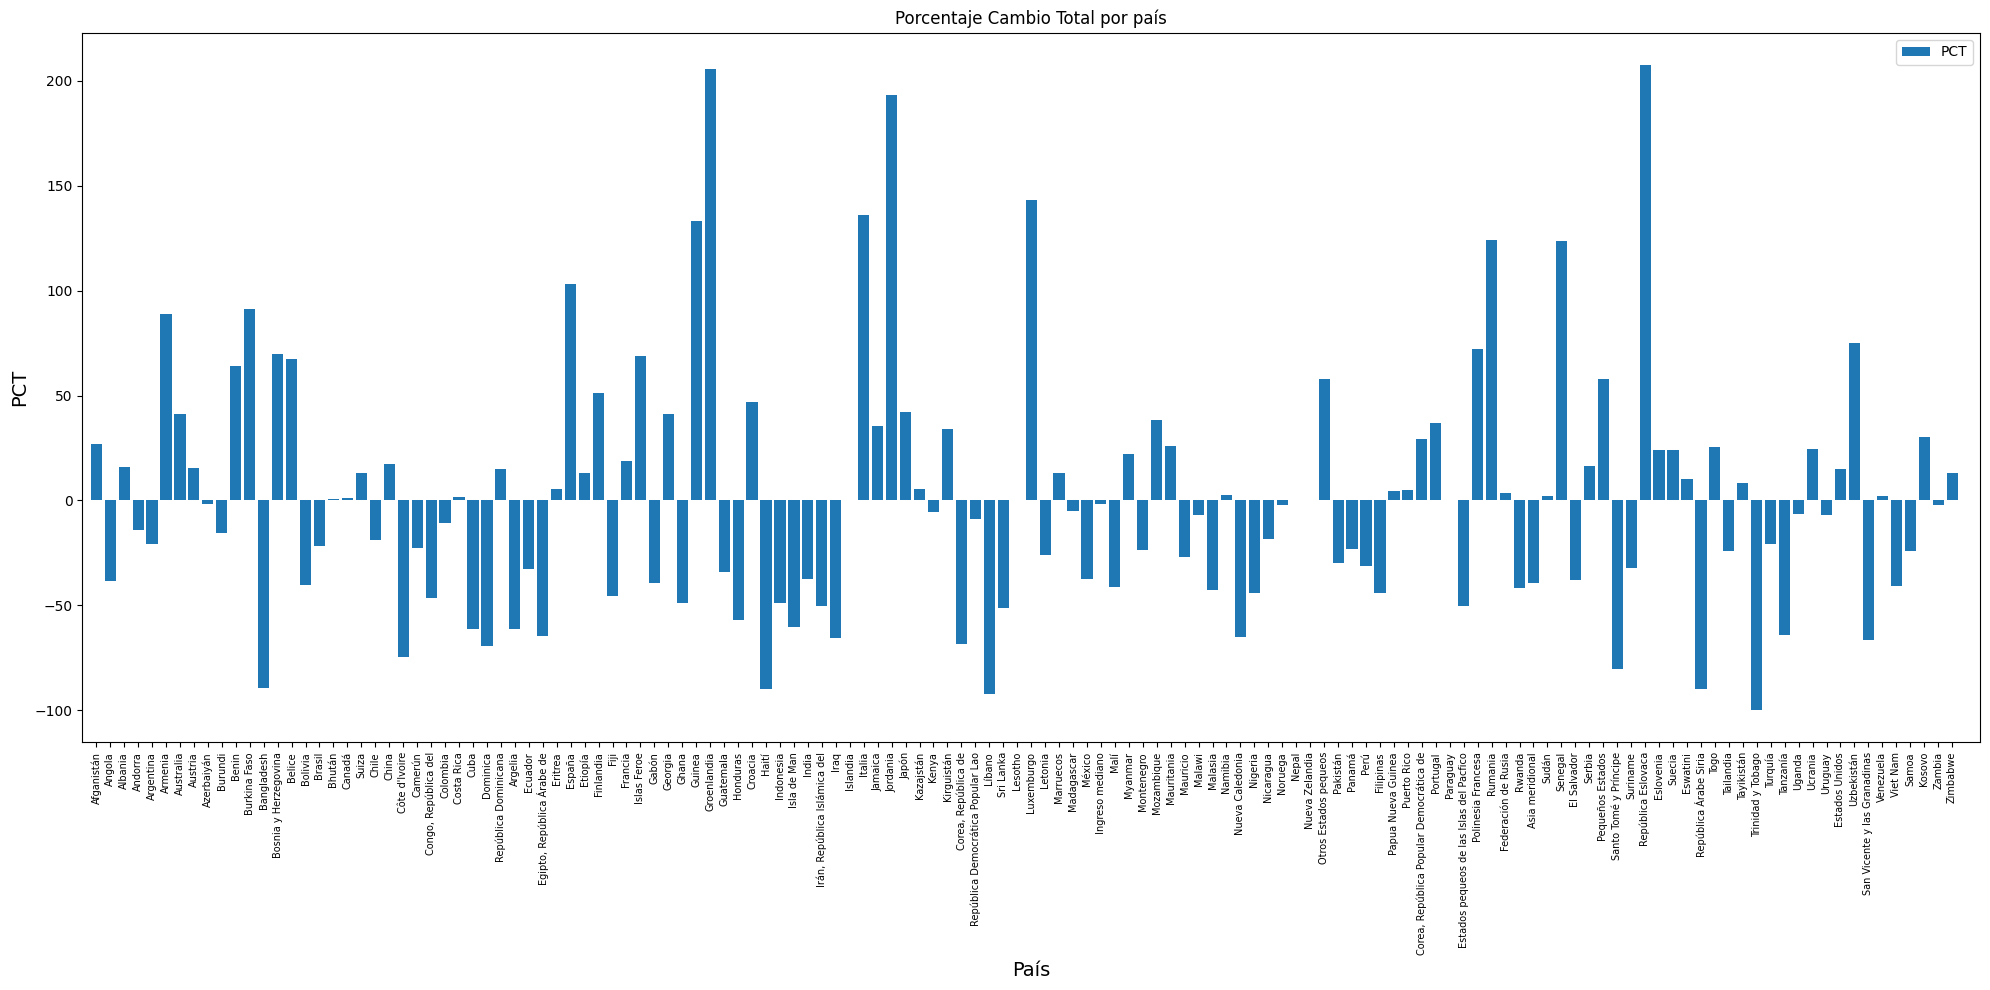

In [ ]:
# Crear gráfico de barras País-PCT

# Ajustar el tamaño del gráfico
plt.figure(figsize=(20, 10))

# Crear las barras del gráfico
plt.bar(ds_paises_filtrado_PCT['Country Name'], ds_paises_filtrado_PCT['PCT'], label='PCT')

# Título y etiquetas de los ejes
plt.xlabel('País', fontsize=14)
plt.ylabel('PCT', fontsize=14)
plt.title('Porcentaje Cambio Total por país')
plt.legend()
plt.xticks(rotation=90, fontsize=7)

# Ajustar límites eje x
plt.xlim(-1, len(ds_paises_filtrado_PCT.index) + 1)

 # Evitar recortes de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

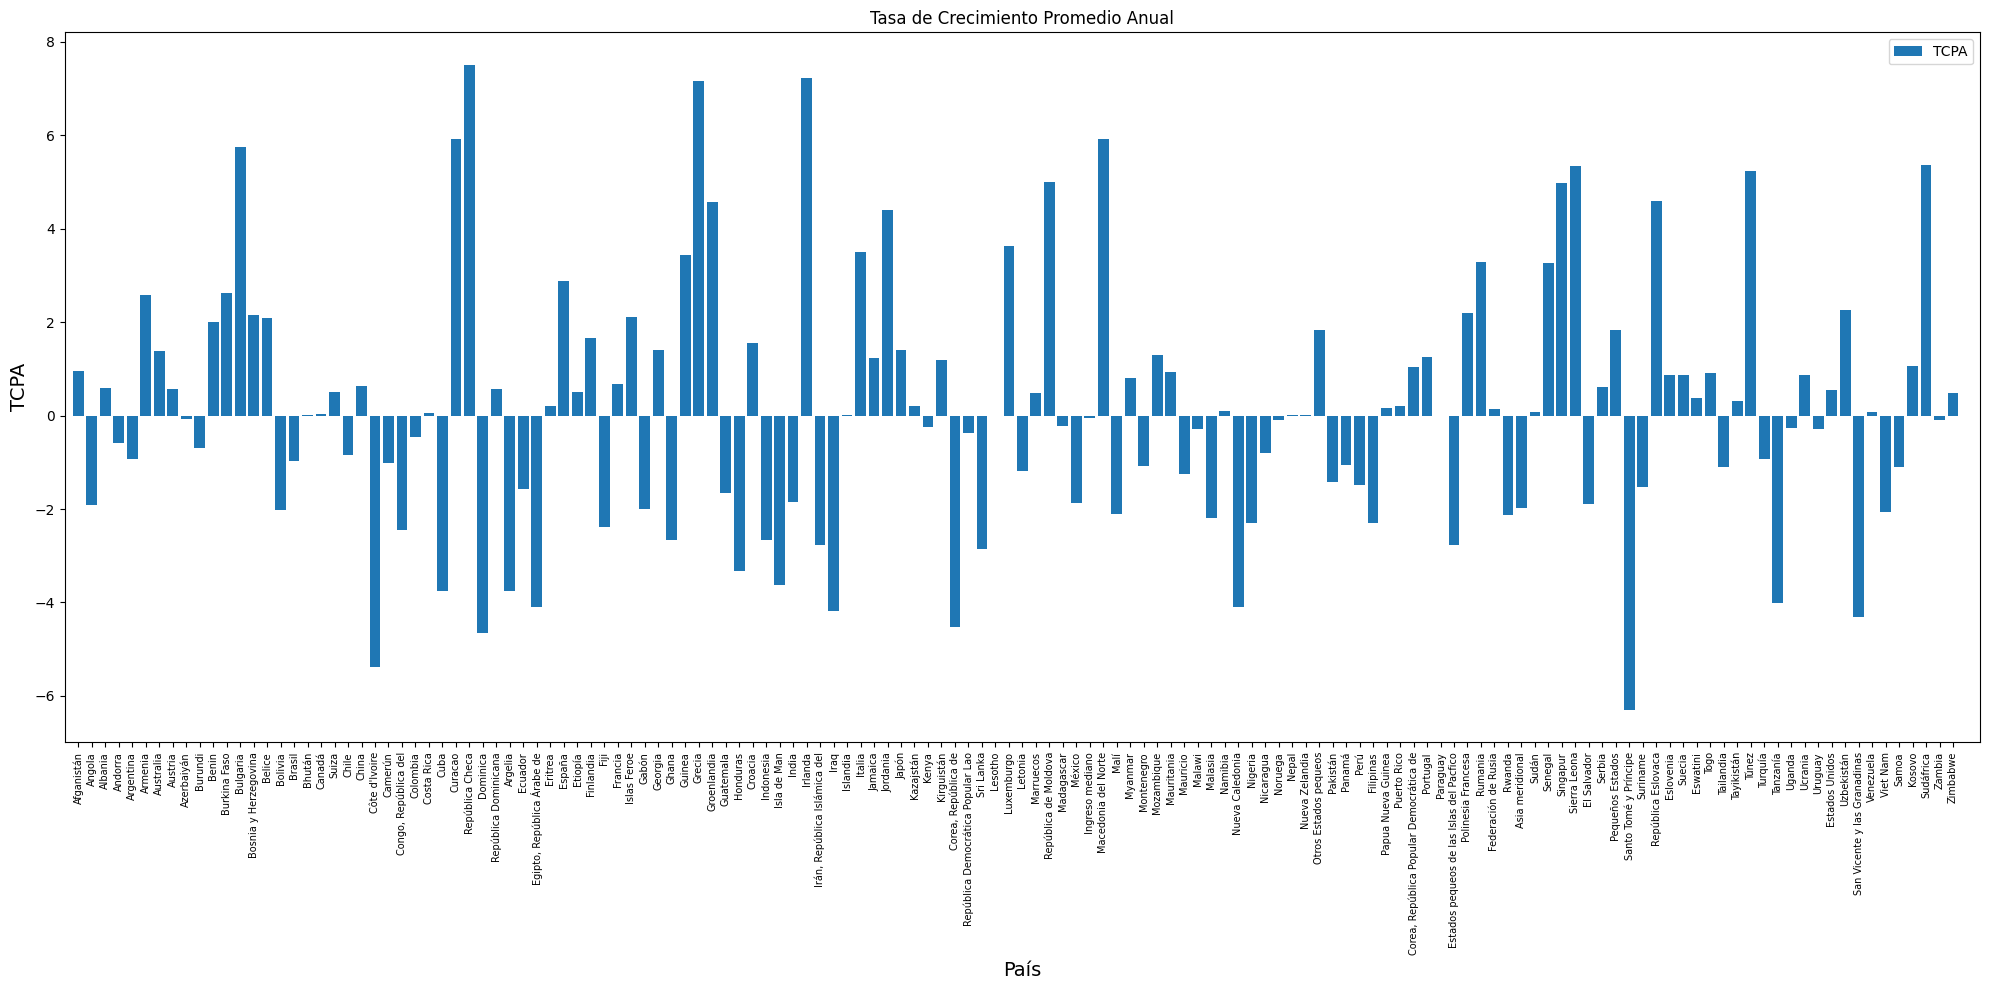

In [ ]:
# Crear gráfico de barras País-TCPA

# Ajustar el tamaño del gráfico
plt.figure(figsize=(20, 10))

# Crear las barras del gráfico
plt.bar(ds_paises_filtrado_TCPA['Country Name'], ds_paises_filtrado_TCPA['TCPA'], label='TCPA')

# Título y etiquetas de los ejes
plt.xlabel('País', fontsize=14)
plt.ylabel('TCPA', fontsize=14)
plt.title('Tasa de Crecimiento Promedio Anual')
plt.legend()
plt.xticks(rotation=90, fontsize=7)

#Ajustar límites eje x
plt.xlim(-1, len(ds_paises_filtrado_TCPA.index) + 1)

# Evitar recortes de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

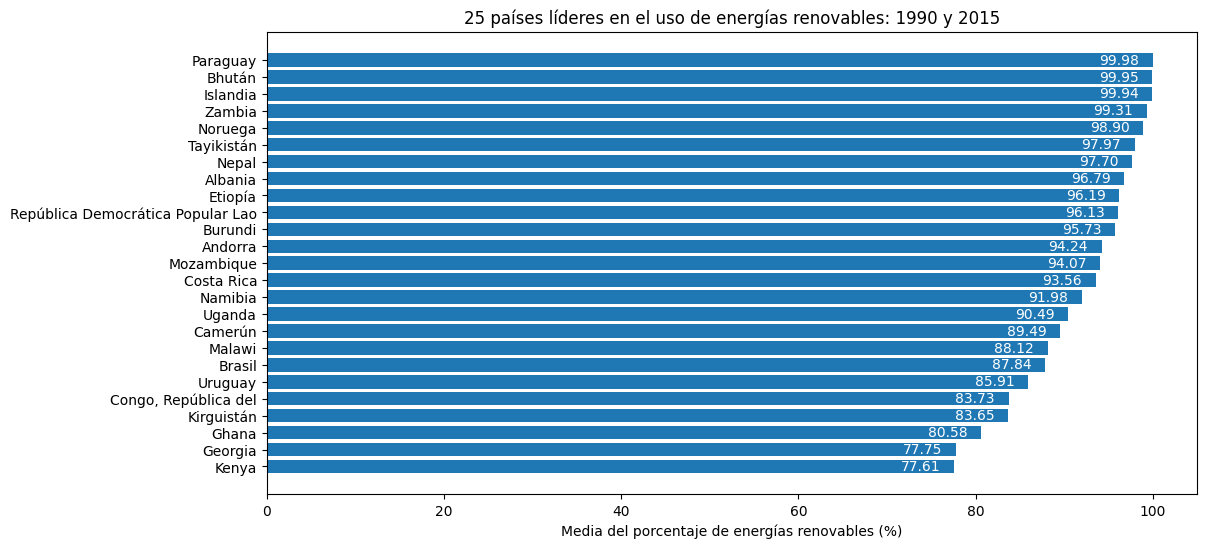

In [ ]:
# Crear gráfico con los 25 países que, en promedio, son líderes en el uso de
# energías renovables para la producción de energía eléctrica

# Ajustar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Ordenar los valores de la media por país de mayor a menor, tomando los primeros 25
top_countries = ds_paises.sort_values(by='media', ascending=False).head(25)

# Crear las barras del gráfico
barras = plt.barh(top_countries['Country Name'], top_countries['media'])

# Etiquetas en cada barra, en el eje x y título
for bar, media in zip(barras, top_countries['media']):
    plt.text(bar.get_width() - 6, bar.get_y() + bar.get_height()/2, f'{media:.2f}',
            va='center', color='white', fontsize=10)
plt.xlabel('Media del porcentaje de energías renovables (%)')
plt.title(f'25 países líderes en el uso de energías renovables: 1990 y 2015')

# Mostrar los mayores valores en la parte superior
plt.gca().invert_yaxis()

# Mostrar el gráfico
plt.show()

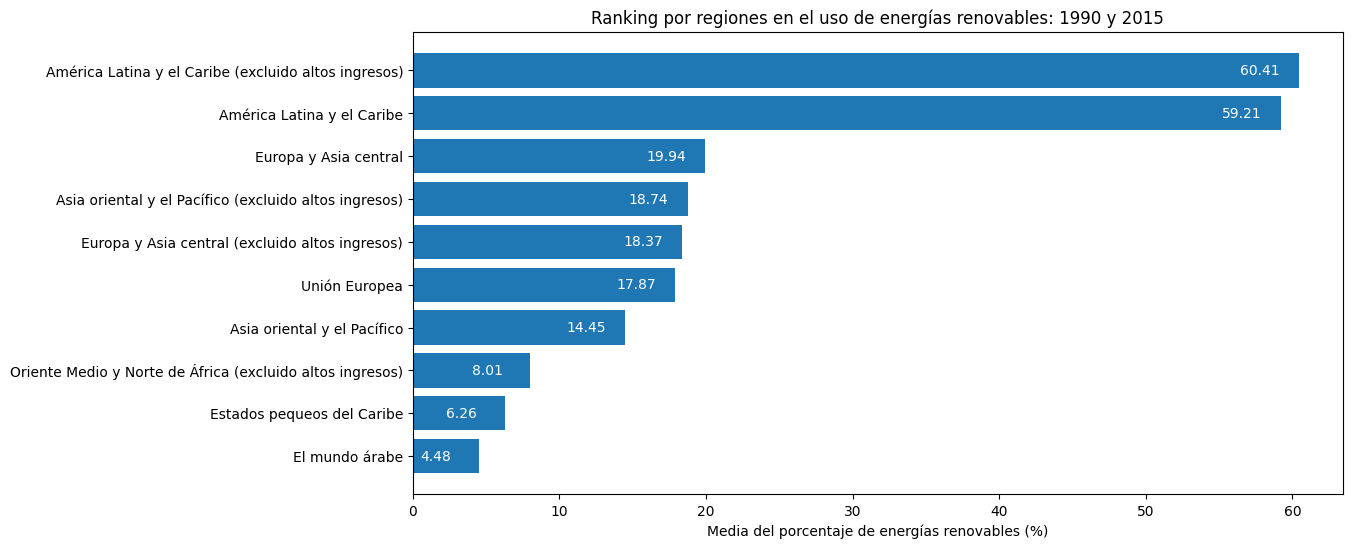

In [ ]:
# Crear gráfico con las regiones que, en promedio, son líderes en el uso de
# energías renovables para la producción de energía eléctrica

# Ajustar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Ordenar los valores de la media por región de mayor a menor
top_regiones = ds_regiones.sort_values(by='media', ascending=False)

# Crear las barras del gráfico
barras = plt.barh(top_regiones['Country Name'], top_regiones['media'])

# Etiquetas en cada barra, en el eje x y título
for bar, media in zip(barras, top_regiones['media']):
    plt.text(bar.get_width() - 4, bar.get_y() + bar.get_height()/2, f'{media:.2f}',
            va='center', color='white', fontsize=10)
plt.xlabel('Media del porcentaje de energías renovables (%)')
plt.title(f'Ranking por regiones en el uso de energías renovables: 1990 y 2015')

# Mostrar los mayores valores en la parte superior
plt.gca().invert_yaxis()

# Mostrar el gráfico
plt.show()

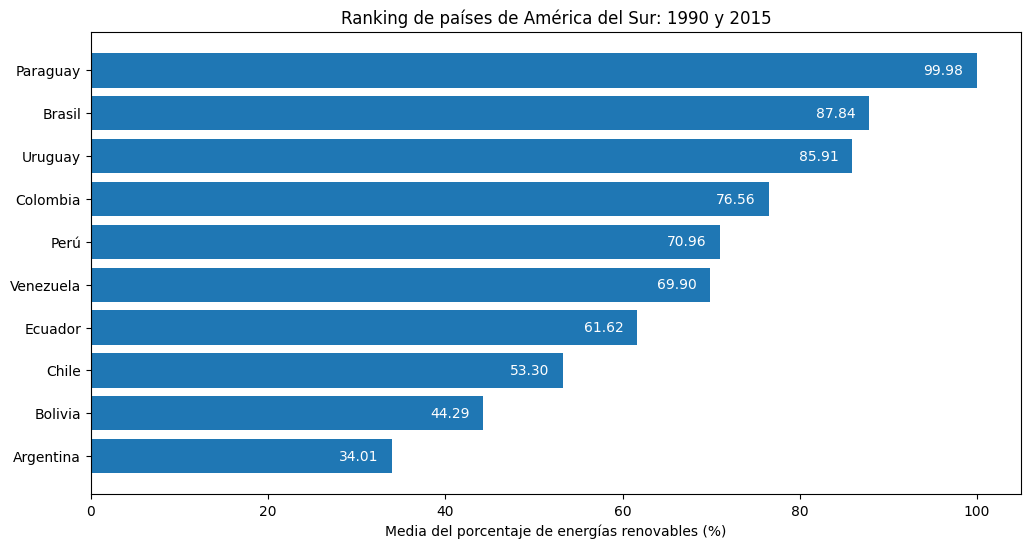

In [ ]:
# Crear gráfico de la media por país de América del Sur en el uso de
# energías renovables para la producción de energía eléctrica

# Ajustar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Listar los países de América del Sur
pads = ['Argentina', 'Bolivia', 'Brasil', 'Chile', 'Colombia',
                      'Ecuador', 'Guyana', 'Paraguay', 'Perú', 'Surinam',
                      'Uruguay', 'Venezuela']

# Filtrar el set de datos de países según la lista anterior
ds_pads = ds_paises.loc[ds_paises['Country Name'].isin(pads)]

# Ordenar los valores de la media de mayor a menor
top_countries = ds_pads.sort_values(by='media', ascending=False)

# Crear las barras del gráfico
barras = plt.barh(top_countries['Country Name'], top_countries['media'])

# Etiquetas en cada barra, en el eje x y título
for bar, media in zip(barras, top_countries['media']):
    plt.text(bar.get_width() - 6, bar.get_y() + bar.get_height()/2, f'{media:.2f}',
            va='center', color='white', fontsize=10)
plt.xlabel('Media del porcentaje de energías renovables (%)')
plt.title(f'Ranking de países de América del Sur: 1990 y 2015')

# Muestra los mayores valores en la parte superior
plt.gca().invert_yaxis()

# Muestra el gráfico
plt.show()

